## Previsão de Ações com Rendes Neurais

Este exemplo utiliza uma rede neural simples, apenas com camadas multiconectadas (Dense) para previsão dos preços de ações. Como o intuito é apenas mostrar como criar um modelo de rede neural, não é utilizado uma *Rede Neural Recorrente* aqui, o que seria mais indicado em previsões de séries temporais. No próximo exemplo esta rede neural será utilizada.


In [195]:
import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow 

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
df = pd.read_csv('data/acoes/DISB34.SA.csv')
df = df.dropna()

df.shape

(1335, 7)

In [197]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,175.470001,175.470001,175.470001,175.470001,175.470001,0
1,2014-01-03,175.470001,175.470001,175.470001,175.470001,175.470001,0
2,2014-01-06,175.470001,175.470001,175.470001,175.470001,175.470001,0
3,2014-01-07,180.100006,180.100006,180.100006,182.070007,182.070007,200
4,2014-01-08,180.410004,180.410004,180.410004,179.710007,179.710007,6400


In [198]:
# Obtém o preço do dia anterior
df['last_close'] = df.apply(lambda row: df['Close'].iloc[row.name - 1], axis=1)
df['last_volume'] = df.apply(lambda row: df['Volume'].iloc[row.name - 1], axis=1)
df = df.iloc[1:].copy()

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,last_close,last_volume
1,2014-01-03,175.470001,175.470001,175.470001,175.470001,175.470001,0,175.470001,0
2,2014-01-06,175.470001,175.470001,175.470001,175.470001,175.470001,0,175.470001,0
3,2014-01-07,180.100006,180.100006,180.100006,182.070007,182.070007,200,175.470001,0
4,2014-01-08,180.410004,180.410004,180.410004,179.710007,179.710007,6400,182.070007,200
5,2014-01-09,182.649994,182.649994,181.130005,179.710007,179.710007,20500,179.710007,6400


In [199]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [200]:
# Selecionando dados para treino do modelo e para validação.
train = df[ :'2018']
test = df['2019': ]

In [201]:
train.tail()

,Open,High,Low,Close,Adj Close,Volume,last_close,last_volume
Date,,,,,,,,
2018-12-20,416.980011,416.980011,413.130005,413.130005,413.130005,900,431.079987,600
2018-12-21,412.000000,412.000000,411.940002,411.940002,411.940002,1000,413.130005,900
2018-12-26,406.429993,406.429993,403.920013,403.920013,403.920013,800,411.940002,1000
2018-12-27,404.000000,404.000000,404.000000,404.000000,404.000000,100,403.920013,800
2018-12-28,416.440002,417.000000,411.209991,411.209991,411.209991,500,404.000000,100


In [202]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,last_close,last_volume
Date,,,,,,,,
2019-01-02,413.309998,413.309998,413.309998,413.309998,413.309998,1500,411.209991,500
2019-01-03,413.000000,413.000000,405.000000,405.000000,405.000000,300,413.309998,1500
2019-01-04,410.619995,410.619995,410.619995,410.619995,410.619995,600,405.000000,300
2019-01-07,415.100006,417.380005,411.910004,411.910004,411.910004,1200,410.619995,600
2019-01-08,413.869995,413.869995,413.869995,413.869995,413.869995,300,411.910004,1200


In [203]:
# Colunas utlizadas para previsão do target.
features = ['Open', 'last_close', 'last_volume']
target = 'Close'

In [204]:
# Dados sem normalização

#x_train, y_train = train[features], train[target]
#x_test, y_test = test[features], test[target]

### Normalização dos dados

In [205]:
# Normalizador para transformar os dados do DataFrame antes da previsão.
scaler_features = MinMaxScaler(feature_range=(0,1))

x_train = pd.DataFrame(
    data= scaler_features.fit_transform(train[features]),
    columns= features
)

x_test = pd.DataFrame(
    data= scaler_features.transform(test[features]),
    columns= features
)

In [206]:
# Normalizador para transformar target  
scaler_target = MinMaxScaler(feature_range=(0,1))

y_train = scaler_target.fit_transform(train.iloc[:, 4:5])
y_test = test[target]

### Criação do modelo de Rede Neural

In [207]:
# Fixando o seed permite que o keras tenha o mesmo resultado em todas 
# as execuções, pelo menos com uma menor margem de diferença entre elas.
np.random.seed(27)
tensorflow.random.set_seed(27)

model = Sequential()

# A função de ativação será 'linear' por padrão, se não informada.
# input_dim: se refere ao número de entradas da RN, ou seja, o número de features
model.add(Dense(30, activation='linear', input_dim=len(features)))
#model.add(Dropout(0.1))

model.add(Dense(60))
#model.add(Dropout(0.1))

model.add(Dense(20, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='msle',
    metrics=['mae']
)

In [208]:
# Treinando do modelo

# epochs: número de vezes que será treinado, sobre todo o dataset.
# batch_size: Número de amostras processadas antes de atualizar os pesos. 
model.fit(x_train, y_train, batch_size=100, epochs=150)

Epoch 1/150
1242/1242 [==============================] - 0s 129us/sample - loss: 0.0320 - mae: 0.1844
Epoch 2/150
1242/1242 [==============================] - 0s 21us/sample - loss: 0.0055 - mae: 0.1029
Epoch 3/150
1242/1242 [==============================] - 0s 29us/sample - loss: 0.0013 - mae: 0.0492
Epoch 4/150
1242/1242 [==============================] - 0s 19us/sample - loss: 3.1524e-04 - mae: 0.0239
Epoch 5/150
1242/1242 [==============================] - 0s 26us/sample - loss: 1.3078e-04 - mae: 0.0137
Epoch 6/150
1242/1242 [==============================] - 0s 29us/sample - loss: 8.7763e-05 - mae: 0.0107
Epoch 7/150
1242/1242 [==============================] - 0s 21us/sample - loss: 7.2505e-05 - mae: 0.0092
Epoch 8/150
1242/1242 [==============================] - 0s 29us/sample - loss: 6.8164e-05 - mae: 0.0090
Epoch 9/150
1242/1242 [==============================] - 0s 22us/sample - loss: 6.0824e-05 - mae: 0.0084
Epoch 10/150
1242/1242 [==============================] - 0s 31us/

In [209]:
pred = model.predict(x_test)
pred[:5]

array([[0.8010204 ],
       [0.8007872 ],
       [0.79138285],
       [0.80642754],
       [0.8030839 ]], dtype=float32)

### Análise da previsão

In [210]:
pred = scaler_target.inverse_transform(pred)
pred[:5]

array([[411.1809 ],
       [411.11078],
       [408.28214],
       [412.80725],
       [411.80157]], dtype=float32)

In [211]:
# Medir a precisão do modelo
# Como é a média de erro, quanto mais próximo de 0 melhor.
metrics.mean_absolute_error(y_test, pred)

3.6583066182065176

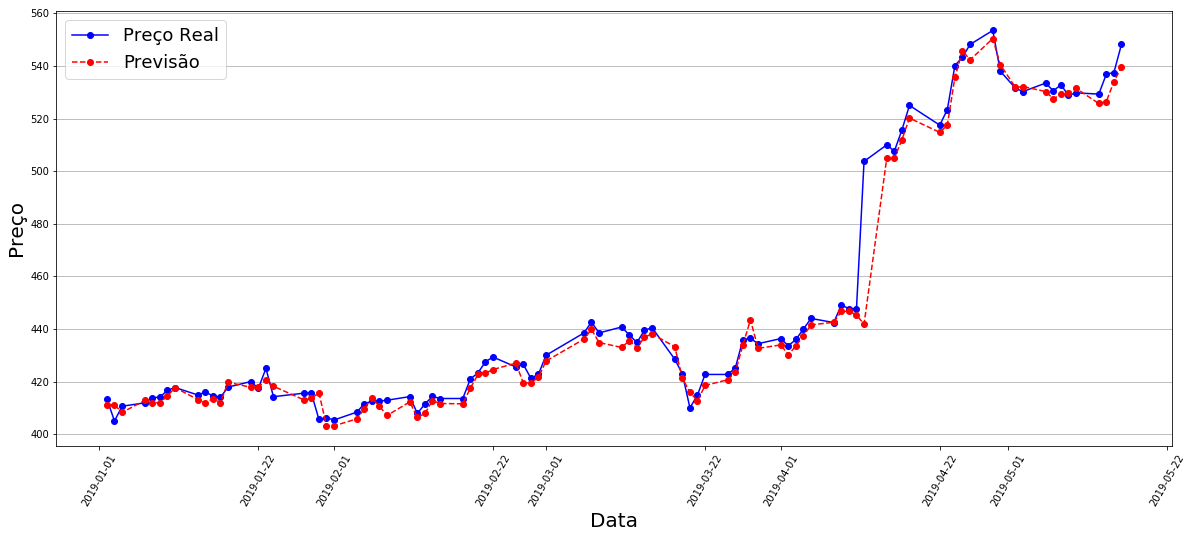

In [212]:
plt.figure(figsize=(20, 8))
plt.plot(test.index, y_test, color='blue', label='Preço Real', linestyle='-', marker='o')
plt.plot(test.index, pred, color='red', label='Previsão', linestyle='--', marker='o')

plt.legend(loc='upper left', prop={'size':18})
plt.xlabel('Data', fontdict={'size':20})
plt.ylabel('Preço', fontdict={'size':20})
plt.xticks(rotation='60')
plt.grid(axis='y')